<a href="https://colab.research.google.com/github/sayakpaul/GAN-Hacks/blob/master/WGAN_GP_Experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Select TensorFlow 2 backend
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
# I'm training on a GPU!
!nvidia-smi

Fri Mar 20 06:05:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Imports
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from IPython.display import clear_output
from imutils import build_montages
from sklearn.utils import shuffle 
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

In [0]:
# Set TensorFlow's and NumPy's random seed and make the plots inline
tf.random.set_seed(42)
np.random.seed(42)
%matplotlib inline

In [5]:
# Gather dataset
((X_train, _), (X_test, _)) = tf.keras.datasets.fashion_mnist.load_data()
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [0]:
# Add a channel dimension
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [0]:
# Concatenate train and test images into one array and normalize
# the pixel values
trainImages = np.concatenate([X_train, X_test])
trainImages = (trainImages.astype("float32") - 127.5) / 127.5

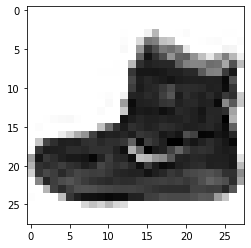

In [8]:
plt.imshow(trainImages[0].reshape(28, 28), cmap=plt.cm.binary)
plt.show()

In [0]:
# Model configuration
LATENT_DIM = 128
HEIGHT = 28
WIDTH = 28
NB_CHANNELS = 1

In [0]:
# Generator
def generator_network():
    generator = Sequential()
    inputShape = (7, 7, 64)
    chanDim = -1

    generator.add(Dense(input_dim=LATENT_DIM, units=512, use_bias=False))
    generator.add(LeakyReLU())
    generator.add(BatchNormalization())

    generator.add(Dense(7 * 7 * 64, use_bias=False))
    generator.add(LeakyReLU())
    generator.add(BatchNormalization())

    generator.add(Reshape(inputShape))
    generator.add(Conv2DTranspose(32, (5, 5), strides=(2, 2),
        padding="same", use_bias=False))
    generator.add((LeakyReLU()))
    generator.add(BatchNormalization(axis=chanDim))

    generator.add(Conv2DTranspose(NB_CHANNELS, (5, 5), strides=(2, 2),
        padding="same", activation="tanh"))

    return generator

In [11]:
generator = generator_network()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              1605632   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 3136)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0

In [0]:
# Discriminator
def disc_network():
    disc = Sequential()
    inputShape = (HEIGHT, WIDTH, NB_CHANNELS)

    disc.add(Conv2D(32, (5, 5), padding="same", strides=(2, 2),
        input_shape=inputShape))
    disc.add(LeakyReLU(alpha=0.2))

    disc.add(Conv2D(64, (5, 5), padding="same", strides=(2, 2)))
    disc.add(LeakyReLU(alpha=0.2))

    disc.add(Flatten())
    disc.add(Dense(512))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Dropout(0.3))
    disc.add(Dense(1))
    
    return disc

In [13]:
disc = disc_network()
disc.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1606144   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)              

In [0]:
# The Wasserstein loss
from tensorflow.keras import backend as K

def wasserstein(y_true, y_pred):
    return - K.mean(y_true * y_pred)

In [0]:
# Compile the critic (in the W-GAN paper the authors referred the discriminator as critic)
disc_opt = Adam(lr=0.0002, beta_1=0.5)
gan_opt = Adam(lr=0.0002, beta_1=0.5)

In [0]:
# Reference: https://colab.research.google.com/drive/14l-3syle0APnRi-HQoTx-oAFZOGvbbSk

@tf.function
def train_gan(num_samples):
    # 1. Generate random noise
    noise = tf.random.normal([num_samples,  LATENT_DIM], dtype=tf.float32)
    
    # 2. Generate fake labels to fool the critic
    fake_labels = tf.ones_like(num_samples, dtype=tf.float32)

    # 3. Generate image and get the loss as well as gradients via the critic
    with tf.GradientTape() as tape:
        generated_images = generator(noise, training=True)
        gen_img_logits = disc(generated_images, training=True)
        gan_loss = wasserstein(fake_labels, gen_img_logits)
    
    gen_gradient = tape.gradient(gan_loss, generator.trainable_variables)
    gan_opt.apply_gradients(zip(gen_gradient, generator.trainable_variables))
    return gan_loss

#-------------------------------------------------------------------------------

def gradient_penalty(real_images, fake_images):
    # Each image would get a random number in the batch 
    # This number would be of shape: (num_samples, 1, 1, 1)
    # Remember each image has h x w x nb_channels
    alpha = np.random.uniform(size=(len(real_images), 1, 1, 1))
    alpha = tf.convert_to_tensor(alpha, dtype=tf.float32)
    
    # Perform interpolation
    interpolated = (alpha * real_images) + ((1 - alpha) * fake_images)
    
    # Compute gradients of the predictions with respect to the interpolated images
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = disc(interpolated, training=True)

    grads = tape.gradient(pred, [interpolated])[0]

    # Compute the Gradient Penalty term
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.)**2)
    
    return gp

#-------------------------------------------------------------------------------

@tf.function
def train_critic(real_images, gp_weight=10.0):
    # 1. Generate random noise to map it to images via the generator
    noise = tf.random.normal([len(real_images),  LATENT_DIM], dtype=tf.float32)
    
    # 2. Prepare the labels
    # -1 -> Fake images, 1 -> Real images
    fake_labels = -tf.ones_like(len(real_images), dtype=tf.float32)
    real_labels = tf.ones_like(len(real_images), dtype=tf.float32)
    
    # 3. Compute the critic loss with GP and update gradients
    with tf.GradientTape() as tape:
        # Map the noise vector to images via the generator, compute the critic logits,
        # and loss
        generated_images = generator(noise, training=True)
        fake_logits = disc(generated_images, training=True)
        fake_loss = wasserstein(fake_labels, fake_logits)

        # Similarly run the original images through the critic, compute the logits,
        # and loss
        real_logits = disc(real_images)
        real_loss = wasserstein(real_labels, real_logits)

        # Compute the final critic loss with the gradient penalty, and backprop
        critic_loss = fake_loss + real_loss
        gp = gradient_penalty(real_images, generated_images)
        total_critic_loss = critic_loss + gp*gp_weight

    disc_gradient = tape.gradient(total_critic_loss, disc.trainable_variables)
    disc_opt.apply_gradients(zip(disc_gradient, disc.trainable_variables))
    
    return total_critic_loss

#-------------------------------------------------------------------------------

In [0]:
# Constants
EPOCHS = 100 
BATCH_SIZE = 512

In [0]:
# Batch and shuffle the data
trainDataset = tf.data.Dataset.from_tensor_slices(trainImages).\
    shuffle(100).\
    batch(BATCH_SIZE)

In [0]:
# Metrics to keep track of the mean loss for eah epoch
gen_metric = tf.keras.metrics.Mean()
disc_metric = tf.keras.metrics.Mean()

In [0]:
# Sample random noise from a normal distribution, we will use this
# to visualize the intermediate results
benchmark_noise = np.random.normal(size=(256, LATENT_DIM))

In [0]:
!rm -rf *.png

In [22]:
######## Training ########
##########################

start = 0

for epoch in tqdm(range(EPOCHS)):
    for (batch_no, dataset) in enumerate(trainDataset):
    # Frequent critic updates in between generator updates
        for _ in range(5):
            critic_loss = train_critic(dataset)
            disc_metric(critic_loss)
    
        # Train the GAN
        gan_loss = train_gan(len(dataset))
        gen_metric(gan_loss)
    
        # Logging
        if batch_no % 200==0:            
            print(f"epoch: {epoch} batch_no: {batch_no} gan_loss: {gen_metric.result():.3f}, "
                f"d_loss: {disc_metric.result():.3f}")
            predicted_images = generator.predict(benchmark_noise)
            predicted_images = ((predicted_images * 127.5) + 127.5).astype("int")
            predicted_images = np.repeat(predicted_images, 3, axis=-1)
            vis = build_montages(predicted_images, (28, 28), (16, 16))[0]
            cv2.imwrite("epoch_" + str(epoch) + "batch_" + str(batch_no) + ".png", vis)

    # Reset the states of the metrics
    gen_metric.reset_states()
    disc_metric.reset_states()

  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 0 batch_no: 0 gan_loss: -0.078, d_loss: 6.137


  1%|          | 1/100 [00:25<42:23, 25.69s/it]

epoch: 1 batch_no: 0 gan_loss: -8.524, d_loss: -7.304


  2%|▏         | 2/100 [00:42<37:25, 22.92s/it]

epoch: 2 batch_no: 0 gan_loss: -1.631, d_loss: -5.340


  3%|▎         | 3/100 [00:58<33:52, 20.95s/it]

epoch: 3 batch_no: 0 gan_loss: 2.299, d_loss: -4.452


  4%|▍         | 4/100 [01:14<31:19, 19.58s/it]

epoch: 4 batch_no: 0 gan_loss: 4.862, d_loss: -3.882


  5%|▌         | 5/100 [01:31<29:29, 18.62s/it]

epoch: 5 batch_no: 0 gan_loss: 5.892, d_loss: -3.506


  6%|▌         | 6/100 [01:47<28:07, 17.95s/it]

epoch: 6 batch_no: 0 gan_loss: 5.912, d_loss: -3.332


  7%|▋         | 7/100 [02:04<27:05, 17.48s/it]

epoch: 7 batch_no: 0 gan_loss: 5.383, d_loss: -3.156


  8%|▊         | 8/100 [02:20<26:16, 17.13s/it]

epoch: 8 batch_no: 0 gan_loss: 7.244, d_loss: -2.825


  9%|▉         | 9/100 [02:36<25:38, 16.91s/it]

epoch: 9 batch_no: 0 gan_loss: 5.717, d_loss: -2.737


 10%|█         | 10/100 [02:53<25:05, 16.73s/it]

epoch: 10 batch_no: 0 gan_loss: 6.810, d_loss: -2.584


 11%|█         | 11/100 [03:09<24:40, 16.63s/it]

epoch: 11 batch_no: 0 gan_loss: 5.964, d_loss: -2.613


 12%|█▏        | 12/100 [03:25<24:15, 16.54s/it]

epoch: 12 batch_no: 0 gan_loss: 5.674, d_loss: -2.491


 13%|█▎        | 13/100 [03:42<23:55, 16.49s/it]

epoch: 13 batch_no: 0 gan_loss: 5.709, d_loss: -2.417


 14%|█▍        | 14/100 [03:58<23:36, 16.47s/it]

epoch: 14 batch_no: 0 gan_loss: 5.825, d_loss: -2.297


 15%|█▌        | 15/100 [04:15<23:19, 16.46s/it]

epoch: 15 batch_no: 0 gan_loss: 5.292, d_loss: -2.133


 16%|█▌        | 16/100 [04:31<22:58, 16.42s/it]

epoch: 16 batch_no: 0 gan_loss: 5.405, d_loss: -2.245


 17%|█▋        | 17/100 [04:47<22:40, 16.39s/it]

epoch: 17 batch_no: 0 gan_loss: 6.109, d_loss: -2.137


 18%|█▊        | 18/100 [05:03<22:22, 16.37s/it]

epoch: 18 batch_no: 0 gan_loss: 6.036, d_loss: -1.996


 19%|█▉        | 19/100 [05:20<22:06, 16.37s/it]

epoch: 19 batch_no: 0 gan_loss: 7.303, d_loss: -2.048


 20%|██        | 20/100 [05:36<21:50, 16.38s/it]

epoch: 20 batch_no: 0 gan_loss: 7.932, d_loss: -2.013


 21%|██        | 21/100 [05:53<21:34, 16.39s/it]

epoch: 21 batch_no: 0 gan_loss: 7.894, d_loss: -1.925


 22%|██▏       | 22/100 [06:09<21:17, 16.38s/it]

epoch: 22 batch_no: 0 gan_loss: 6.844, d_loss: -1.989


 23%|██▎       | 23/100 [06:25<21:02, 16.39s/it]

epoch: 23 batch_no: 0 gan_loss: 7.813, d_loss: -1.907


 24%|██▍       | 24/100 [06:42<20:45, 16.39s/it]

epoch: 24 batch_no: 0 gan_loss: 7.146, d_loss: -1.806


 25%|██▌       | 25/100 [06:58<20:30, 16.40s/it]

epoch: 25 batch_no: 0 gan_loss: 6.971, d_loss: -1.691


 26%|██▌       | 26/100 [07:15<20:13, 16.40s/it]

epoch: 26 batch_no: 0 gan_loss: 7.607, d_loss: -1.800


 27%|██▋       | 27/100 [07:31<19:56, 16.39s/it]

epoch: 27 batch_no: 0 gan_loss: 7.333, d_loss: -1.713


 28%|██▊       | 28/100 [07:47<19:39, 16.38s/it]

epoch: 28 batch_no: 0 gan_loss: 9.708, d_loss: -1.906


 29%|██▉       | 29/100 [08:04<19:23, 16.38s/it]

epoch: 29 batch_no: 0 gan_loss: 10.081, d_loss: -1.859


 30%|███       | 30/100 [08:20<19:06, 16.38s/it]

epoch: 30 batch_no: 0 gan_loss: 10.921, d_loss: -1.698


 31%|███       | 31/100 [08:37<18:49, 16.37s/it]

epoch: 31 batch_no: 0 gan_loss: 11.486, d_loss: -1.883


 32%|███▏      | 32/100 [08:53<18:31, 16.35s/it]

epoch: 32 batch_no: 0 gan_loss: 10.296, d_loss: -1.715


 33%|███▎      | 33/100 [09:09<18:14, 16.33s/it]

epoch: 33 batch_no: 0 gan_loss: 10.115, d_loss: -1.766


 34%|███▍      | 34/100 [09:25<17:57, 16.33s/it]

epoch: 34 batch_no: 0 gan_loss: 11.328, d_loss: -1.639


 35%|███▌      | 35/100 [09:42<17:40, 16.32s/it]

epoch: 35 batch_no: 0 gan_loss: 10.215, d_loss: -1.771


 36%|███▌      | 36/100 [09:58<17:24, 16.32s/it]

epoch: 36 batch_no: 0 gan_loss: 9.317, d_loss: -1.524


 37%|███▋      | 37/100 [10:14<17:07, 16.31s/it]

epoch: 37 batch_no: 0 gan_loss: 9.731, d_loss: -1.553


 38%|███▊      | 38/100 [10:31<16:51, 16.31s/it]

epoch: 38 batch_no: 0 gan_loss: 9.929, d_loss: -1.590


 39%|███▉      | 39/100 [10:47<16:34, 16.31s/it]

epoch: 39 batch_no: 0 gan_loss: 8.653, d_loss: -1.513


 40%|████      | 40/100 [11:03<16:18, 16.30s/it]

epoch: 40 batch_no: 0 gan_loss: 9.416, d_loss: -1.500


 41%|████      | 41/100 [11:20<16:01, 16.29s/it]

epoch: 41 batch_no: 0 gan_loss: 9.115, d_loss: -1.532


 42%|████▏     | 42/100 [11:36<15:45, 16.29s/it]

epoch: 42 batch_no: 0 gan_loss: 8.869, d_loss: -1.493


 43%|████▎     | 43/100 [11:52<15:28, 16.29s/it]

epoch: 43 batch_no: 0 gan_loss: 9.990, d_loss: -1.606


 44%|████▍     | 44/100 [12:08<15:12, 16.29s/it]

epoch: 44 batch_no: 0 gan_loss: 9.416, d_loss: -1.475


 45%|████▌     | 45/100 [12:25<14:56, 16.30s/it]

epoch: 45 batch_no: 0 gan_loss: 8.828, d_loss: -1.392


 46%|████▌     | 46/100 [12:41<14:40, 16.30s/it]

epoch: 46 batch_no: 0 gan_loss: 7.372, d_loss: -1.274


 47%|████▋     | 47/100 [12:57<14:23, 16.29s/it]

epoch: 47 batch_no: 0 gan_loss: 8.582, d_loss: -1.415


 48%|████▊     | 48/100 [13:14<14:06, 16.28s/it]

epoch: 48 batch_no: 0 gan_loss: 8.295, d_loss: -1.423


 49%|████▉     | 49/100 [13:30<13:50, 16.28s/it]

epoch: 49 batch_no: 0 gan_loss: 8.456, d_loss: -1.380


 50%|█████     | 50/100 [13:46<13:34, 16.28s/it]

epoch: 50 batch_no: 0 gan_loss: 8.877, d_loss: -1.429


 51%|█████     | 51/100 [14:02<13:18, 16.30s/it]

epoch: 51 batch_no: 0 gan_loss: 7.314, d_loss: -1.321


 52%|█████▏    | 52/100 [14:19<13:02, 16.31s/it]

epoch: 52 batch_no: 0 gan_loss: 7.572, d_loss: -1.297


 53%|█████▎    | 53/100 [14:35<12:47, 16.33s/it]

epoch: 53 batch_no: 0 gan_loss: 8.452, d_loss: -1.411


 54%|█████▍    | 54/100 [14:52<12:31, 16.34s/it]

epoch: 54 batch_no: 0 gan_loss: 8.377, d_loss: -1.394


 55%|█████▌    | 55/100 [15:08<12:15, 16.35s/it]

epoch: 55 batch_no: 0 gan_loss: 7.997, d_loss: -1.292


 56%|█████▌    | 56/100 [15:24<11:58, 16.33s/it]

epoch: 56 batch_no: 0 gan_loss: 7.549, d_loss: -1.527


 57%|█████▋    | 57/100 [15:41<11:42, 16.34s/it]

epoch: 57 batch_no: 0 gan_loss: 5.882, d_loss: -1.199


 58%|█████▊    | 58/100 [15:57<11:26, 16.33s/it]

epoch: 58 batch_no: 0 gan_loss: 7.192, d_loss: -1.118


 59%|█████▉    | 59/100 [16:13<11:10, 16.35s/it]

epoch: 59 batch_no: 0 gan_loss: 8.079, d_loss: -1.237


 60%|██████    | 60/100 [16:30<10:54, 16.37s/it]

epoch: 60 batch_no: 0 gan_loss: 8.768, d_loss: -1.233


 61%|██████    | 61/100 [16:46<10:39, 16.38s/it]

epoch: 61 batch_no: 0 gan_loss: 9.071, d_loss: -1.307


 62%|██████▏   | 62/100 [17:02<10:22, 16.39s/it]

epoch: 62 batch_no: 0 gan_loss: 6.255, d_loss: -1.188


 63%|██████▎   | 63/100 [17:19<10:05, 16.36s/it]

epoch: 63 batch_no: 0 gan_loss: 8.465, d_loss: -1.267


 64%|██████▍   | 64/100 [17:35<09:48, 16.34s/it]

epoch: 64 batch_no: 0 gan_loss: 7.480, d_loss: -1.196


 65%|██████▌   | 65/100 [17:51<09:31, 16.32s/it]

epoch: 65 batch_no: 0 gan_loss: 7.513, d_loss: -1.223


 66%|██████▌   | 66/100 [18:08<09:14, 16.31s/it]

epoch: 66 batch_no: 0 gan_loss: 9.560, d_loss: -1.194


 67%|██████▋   | 67/100 [18:24<08:57, 16.29s/it]

epoch: 67 batch_no: 0 gan_loss: 9.282, d_loss: -1.241


 68%|██████▊   | 68/100 [18:40<08:41, 16.30s/it]

epoch: 68 batch_no: 0 gan_loss: 8.993, d_loss: -1.336


 69%|██████▉   | 69/100 [18:56<08:25, 16.29s/it]

epoch: 69 batch_no: 0 gan_loss: 8.253, d_loss: -1.148


 70%|███████   | 70/100 [19:13<08:08, 16.29s/it]

epoch: 70 batch_no: 0 gan_loss: 7.762, d_loss: -1.240


 71%|███████   | 71/100 [19:29<07:52, 16.29s/it]

epoch: 71 batch_no: 0 gan_loss: 9.607, d_loss: -1.308


 72%|███████▏  | 72/100 [19:45<07:36, 16.29s/it]

epoch: 72 batch_no: 0 gan_loss: 9.070, d_loss: -1.322


 73%|███████▎  | 73/100 [20:02<07:19, 16.30s/it]

epoch: 73 batch_no: 0 gan_loss: 8.750, d_loss: -1.302


 74%|███████▍  | 74/100 [20:18<07:04, 16.33s/it]

epoch: 74 batch_no: 0 gan_loss: 6.878, d_loss: -1.077


 75%|███████▌  | 75/100 [20:34<06:48, 16.34s/it]

epoch: 75 batch_no: 0 gan_loss: 6.662, d_loss: -1.062


 76%|███████▌  | 76/100 [20:51<06:32, 16.33s/it]

epoch: 76 batch_no: 0 gan_loss: 8.333, d_loss: -1.176


 77%|███████▋  | 77/100 [21:07<06:15, 16.31s/it]

epoch: 77 batch_no: 0 gan_loss: 9.296, d_loss: -1.337


 78%|███████▊  | 78/100 [21:23<05:58, 16.30s/it]

epoch: 78 batch_no: 0 gan_loss: 7.884, d_loss: -1.150


 79%|███████▉  | 79/100 [21:40<05:42, 16.30s/it]

epoch: 79 batch_no: 0 gan_loss: 9.445, d_loss: -1.019


 80%|████████  | 80/100 [21:56<05:25, 16.28s/it]

epoch: 80 batch_no: 0 gan_loss: 8.185, d_loss: -1.056


 81%|████████  | 81/100 [22:12<05:09, 16.28s/it]

epoch: 81 batch_no: 0 gan_loss: 6.513, d_loss: -0.998


 82%|████████▏ | 82/100 [22:28<04:52, 16.27s/it]

epoch: 82 batch_no: 0 gan_loss: 8.651, d_loss: -1.208


 83%|████████▎ | 83/100 [22:45<04:36, 16.27s/it]

epoch: 83 batch_no: 0 gan_loss: 8.544, d_loss: -1.104


 84%|████████▍ | 84/100 [23:01<04:20, 16.27s/it]

epoch: 84 batch_no: 0 gan_loss: 9.567, d_loss: -1.520


 85%|████████▌ | 85/100 [23:17<04:04, 16.28s/it]

epoch: 85 batch_no: 0 gan_loss: 9.239, d_loss: -1.339


 86%|████████▌ | 86/100 [23:33<03:47, 16.27s/it]

epoch: 86 batch_no: 0 gan_loss: 8.800, d_loss: -1.159


 87%|████████▋ | 87/100 [23:50<03:31, 16.27s/it]

epoch: 87 batch_no: 0 gan_loss: 8.518, d_loss: -1.364


 88%|████████▊ | 88/100 [24:06<03:15, 16.27s/it]

epoch: 88 batch_no: 0 gan_loss: 9.082, d_loss: -1.416


 89%|████████▉ | 89/100 [24:22<02:59, 16.28s/it]

epoch: 89 batch_no: 0 gan_loss: 9.068, d_loss: -1.515


 90%|█████████ | 90/100 [24:39<02:42, 16.28s/it]

epoch: 90 batch_no: 0 gan_loss: 9.177, d_loss: -1.193


 91%|█████████ | 91/100 [24:55<02:26, 16.29s/it]

epoch: 91 batch_no: 0 gan_loss: 10.054, d_loss: -1.244


 92%|█████████▏| 92/100 [25:11<02:10, 16.30s/it]

epoch: 92 batch_no: 0 gan_loss: 10.390, d_loss: -1.382


 93%|█████████▎| 93/100 [25:27<01:54, 16.30s/it]

epoch: 93 batch_no: 0 gan_loss: 8.779, d_loss: -1.219


 94%|█████████▍| 94/100 [25:44<01:37, 16.31s/it]

epoch: 94 batch_no: 0 gan_loss: 7.704, d_loss: -1.325


 95%|█████████▌| 95/100 [26:00<01:21, 16.32s/it]

epoch: 95 batch_no: 0 gan_loss: 9.088, d_loss: -1.348


 96%|█████████▌| 96/100 [26:17<01:05, 16.34s/it]

epoch: 96 batch_no: 0 gan_loss: 8.883, d_loss: -1.265


 97%|█████████▋| 97/100 [26:33<00:49, 16.40s/it]

epoch: 97 batch_no: 0 gan_loss: 7.914, d_loss: -0.959


 98%|█████████▊| 98/100 [26:50<00:32, 16.44s/it]

epoch: 98 batch_no: 0 gan_loss: 6.982, d_loss: -1.091


 99%|█████████▉| 99/100 [27:06<00:16, 16.49s/it]

epoch: 99 batch_no: 0 gan_loss: 6.451, d_loss: -0.903


100%|██████████| 100/100 [27:23<00:00, 16.43s/it]


In [0]:
def show_montage(image_path):
    montage_1 =  plt.imread(image_path)
    plt.imshow(montage_1, cmap=plt.cm.binary)
    plt.show()

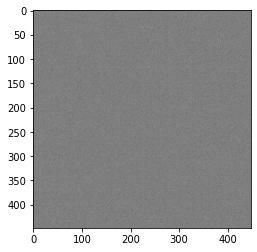

In [25]:
montage_2 =  plt.imread("epoch_0batch_0.png")
plt.imshow(montage_2)
plt.show()

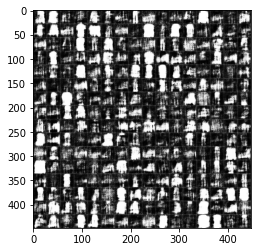

In [26]:
montage_3 =  plt.imread("epoch_1batch_0.png")
plt.imshow(montage_3)
plt.show()

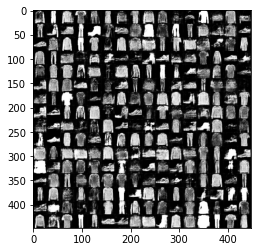

In [27]:
montage_4 =  plt.imread("epoch_8batch_0.png")
plt.imshow(montage_4)
plt.show()

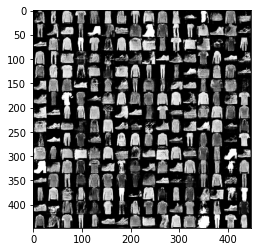

In [28]:
montage_5 =  plt.imread("epoch_20batch_0.png")
plt.imshow(montage_5)
plt.show()